In [1]:
import simpy
from lib.core import NetworkTap, Switch, PacketSource, PacketSink#, visualize_topology
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

# Credits
The original idea and implementation for this exercise comes from the website of Greg Bernstein that can be viewed here: https://www.grotto-networking.com/DiscreteEventPython.html
Current implementation for 

# Uniform distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html#numpy.random.Generator.random

In [2]:
SIZE = 10000

In [3]:
x = rng.random(size=SIZE)
x, x.min(),x.mean(),x.max()

(array([0.43169979, 0.32536145, 0.17389233, ..., 0.3281878 , 0.37647377,
        0.49061487]),
 0.00022358541338907134,
 0.5022409704354993,
 0.9999691545968898)

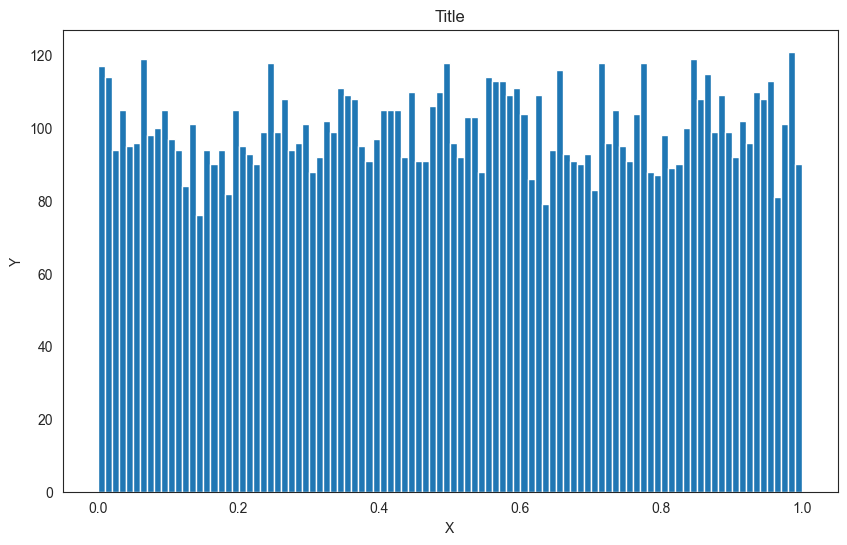

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Exponential distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.exponential.html

In [5]:
x = rng.exponential(scale=1, size=SIZE)
x, x.min(),x.mean(),x.max()

(array([0.26747459, 0.44830639, 0.01807496, ..., 0.82555289, 1.97859527,
        1.56471834]),
 0.00011003348908727644,
 0.9860717207616866,
 9.401133060430023)

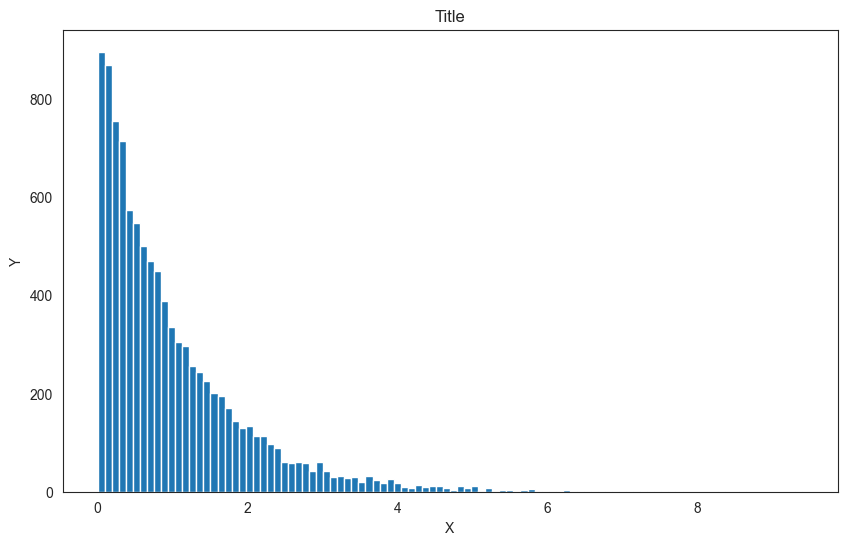

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Normal distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html

In [7]:
x = rng.normal(loc=0, scale=1, size=SIZE)
x, x.min(),x.mean(),x.max()

(array([ 1.10070648, -0.35500604,  1.08146003, ...,  0.66204221,
         0.51228522,  1.20819416]),
 -3.9832204647174057,
 -0.00015999071922054853,
 3.7117410970513576)

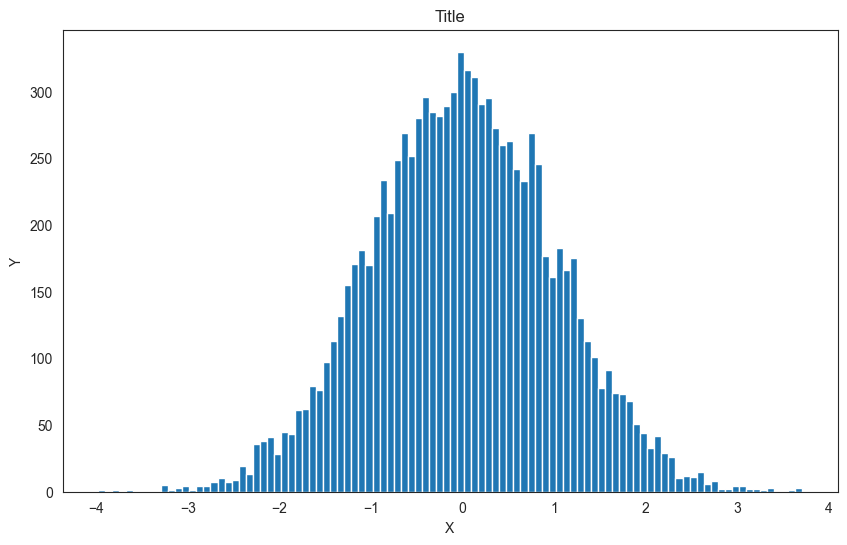

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Simulation Source - Sink

In [9]:
# create Simpy environment
env = simpy.Environment()

# create simple sink for packets
sink = PacketSink(env, "sink", debug=True)

# create a packet source
source = PacketSource(
    env,
    "source01",
    packet_interval=1, # interval between individual packets in simulation units
    packet_size=10 # packet size in Bytes
)

# link them together
source.destination = sink

# run the simulation
simulation_time = 20
env.run(until=simulation_time)

2023-09-18T15:12:54.154555+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   1.00. Processed: Packet(id=     0, size= 10.00, source=source01)
2023-09-18T15:12:54.154555+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   2.00. Processed: Packet(id=     1, size= 10.00, source=source01)
2023-09-18T15:12:54.155553+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   3.00. Processed: Packet(id=     2, size= 10.00, source=source01)
2023-09-18T15:12:54.155553+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time   4.00. Processed: Packet(id=     3, size= 10.00, source=source01)
2023-09-18T15:12:54.156570+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time   5.00. Processed: Packet(id=     4, size= 10.00, source=source01)
2023-09-18T15:12:54.157551+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time   6.00. Processed: Packet(id=     5, size= 10.0

## Task
* Modify the simulation code above to have 2 packet sources with varying sizes and interarrival times.
* Using the built-in partial function, experiment with the use of statistical distributions for packet sizes and interarrivals.

# Simulation Source - Switch - Sink

In [10]:
env = simpy.Environment()

sink = PacketSink(env, "sink", debug=True)

switch = Switch(
    env,
    "switch01",
    num_ports=4, # how many ports does the switch have. IMPORTANT: port is a bi-partisan connection so it actually represents 2 physical ports on a real-world switch
    port_capacity=100, # queue lenght in Bytes
    port_transmission_rate=1000 # bits/s
) 

source = PacketSource(env, "source01", packet_interval=partial(rng.normal, 2,0.5), packet_size=partial(rng.exponential, 50))


source.destination = switch.ports[0]
switch.ports[0].destination = sink

simulation_time = 200
env.run(until=simulation_time)

2023-09-18T15:12:54.241740+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   1.52. Processed: Packet(id=    19, size= 33.00, source=source01)
2023-09-18T15:12:54.242742+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   6.95. Processed: Packet(id=    22, size= 14.00, source=source01)
2023-09-18T15:12:54.242742+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   8.45. Processed: Packet(id=    23, size= 32.00, source=source01)
2023-09-18T15:12:54.242742+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time  11.16. Processed: Packet(id=    24, size= 81.00, source=source01)
2023-09-18T15:12:54.243742+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time  12.54. Processed: Packet(id=    25, size= 10.00, source=source01)
2023-09-18T15:12:54.244740+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time  16.27. Processed: Packet(id=    27, size= 12.0

## How long were packets in the system? 

In [11]:
sink.delays, sink.arrivals, sink.interarrivals

([0.264,
  0.1120000000000001,
  0.2560000000000002,
  0.6479999999999997,
  0.08000000000000007,
  0.09600000000000009,
  0.09600000000000009,
  0.31200000000000117,
  0.6640000000000015,
  0.08800000000000097,
  0.5839999999999996,
  0.6559999999999988,
  0.5039999999999978,
  0.11999999999999744,
  0.19200000000000017,
  0.1839999999999975,
  0.30400000000000205,
  0.14399999999999835,
  0.7280000000000015,
  0.24799999999999756,
  0.11999999999999744,
  0.22400000000000375,
  0.02400000000000091,
  0.09600000000000364,
  0.016000000000005343,
  0.3119999999999976,
  0.3919999999999959,
  0.1599999999999966,
  0.1039999999999992,
  0.13599999999999568,
  0.48799999999999955,
  0.7519999999999953,
  0.43200000000000216,
  0.055999999999997385,
  0.031999999999996476,
  0.4000000000000057,
  0.30400000000000205,
  0.45600000000000307,
  0.0799999999999983,
  0.14400000000000546,
  0.3119999999999976,
  0.3359999999999985,
  0.6640000000000015,
  0.007999999999995566,
  0.0079999999999

# Simulation Source - Switch - Sink with Network Tap

In [12]:
env = simpy.Environment()

sink = PacketSink(env, "sink", debug=True)

switch = Switch(
    env,
    "switch01",
    num_ports=4, # how many ports does the switch have. IMPORTANT: port is a bi-partisan connection so it actually represents 2 physical ports on a real-world switch
    port_capacity=100, # queue lenght in Bytes
    port_transmission_rate=1000 # bits/s
)
tap = NetworkTap(
    env,
    port=switch.ports[0] # port to be monitored
)

source = PacketSource(env, "source01", packet_interval=partial(rng.normal, 2,0.5), packet_size=partial(rng.exponential, 50))


source.destination = switch.ports[0]
switch.ports[0].destination = sink

simulation_time = 200
env.run(until=simulation_time)

2023-09-18T15:12:54.449650+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   2.34. Processed: Packet(id=   116, size= 62.00, source=source01)
2023-09-18T15:12:54.450648+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   3.66. Processed: Packet(id=   117, size=  4.00, source=source01)
2023-09-18T15:12:54.451650+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   5.88. Processed: Packet(id=   118, size= 45.00, source=source01)
2023-09-18T15:12:54.452649+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time   7.49. Processed: Packet(id=   119, size= 39.00, source=source01)
2023-09-18T15:12:54.453654+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time   9.83. Processed: Packet(id=   120, size= 22.00, source=source01)
2023-09-18T15:12:54.453654+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time  11.22. Processed: Packet(id=   121, size= 25.0

In [13]:
tap

NetworkTap(Last 10 packet counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], last 10 byte counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# M/M/1 System

Last 10 waits: 4.168, 3.048, 0.794, 1.366, 0.803, 1.823, 1.162, 0.724, 0.008, 1.039
Last 10 queue sizes: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
Last 10 sink arrival times: 0.741, 1.364, 0.052, 3.673, 0.046, 1.301, 0.497, 9.410, 2.071, 2.493
average wait = 1.283
received: 3939, dropped 0, sent 3939
loss rate: 0.0
average system occupancy: 0.639


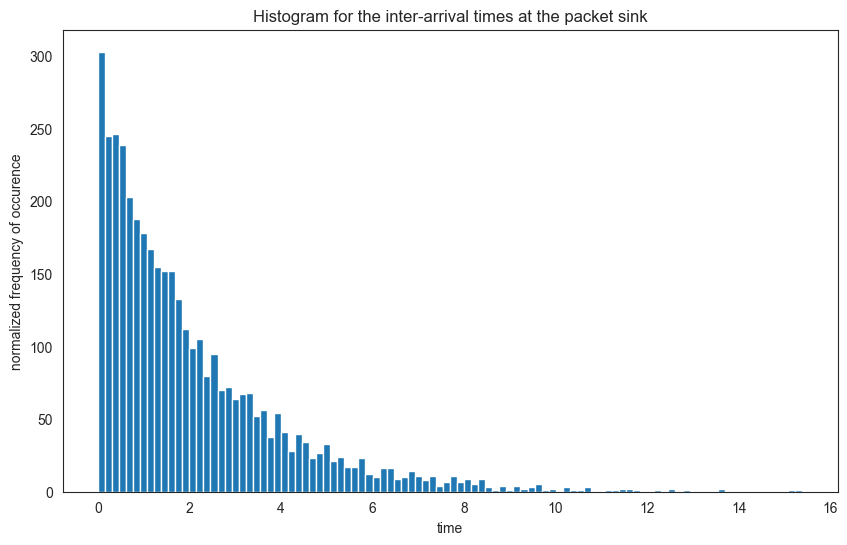

In [14]:
import random
import functools
import simpy
import matplotlib.pyplot as plt
from lib.SimComponents import PacketGenerator, PacketSink, SwitchPort, PortMonitor

adist = functools.partial(random.expovariate, 0.5)
sdist = functools.partial(random.expovariate, 0.01)  # mean size 100 bytes
samp_dist = functools.partial(random.expovariate, 1.0)
port_rate = 1000.0

env = simpy.Environment()  # Create the SimPy environment
# Create the packet generators and sink
ps = PacketSink(env, debug=False, rec_arrivals=True)
pg = PacketGenerator(env, "Greg", adist, sdist)
switch_port = SwitchPort(env, port_rate, qlimit=10000)
# Using a PortMonitor to track queue sizes over time
pm = PortMonitor(env, switch_port, samp_dist)
# Wire packet generators, switch ports, and sinks together
pg.out = switch_port
switch_port.out = ps
# Run it
env.run(until=8000)
print("Last 10 waits: "  + ", ".join(["{:.3f}".format(x) for x in ps.waits[-10:]]))
print("Last 10 queue sizes: {}".format(pm.sizes[-10:]))
print("Last 10 sink arrival times: " + ", ".join(["{:.3f}".format(x) for x in ps.arrivals[-10:]]))
print("average wait = {:.3f}".format(sum(ps.waits)/len(ps.waits)))
print("received: {}, dropped {}, sent {}".format(switch_port.packets_rec, switch_port.packets_drop, pg.packets_sent))
print("loss rate: {}".format(float(switch_port.packets_drop)/switch_port.packets_rec))
print("average system occupancy: {:.3f}".format(float(sum(pm.sizes))/len(pm.sizes)))


fig, ax = plt.subplots(figsize=(10,6))
ax.hist(ps.arrivals, bins=100)
ax.set_xlabel("time")
ax.set_ylabel("normalized frequency of occurence")
ax.set_title("Histogram for the inter-arrival times at the packet sink")
plt.show()

# More complex systems of queues

In [15]:
"""
Use of SimComponents to simulate the network of queues from Homework #6 problem 1, Fall 2014.
See corresponding solution set for mean delay calculation based on Burkes theorem.

Copyright 2014 Dr. Greg M. Bernstein
Released under the MIT license
"""
import random
import functools

import simpy

from lib.SimComponents import PacketGenerator, PacketSink, SwitchPort, RandomBrancher


if __name__ == '__main__':
    # Set up arrival and packet size distributions
    # Using Python functools to create callable functions for random variates with fixed parameters.
    # each call to these will produce a new random value.
    mean_pkt_size = 100.0  # in bytes
    adist1 = functools.partial(random.expovariate, 2.0)
    adist2 = functools.partial(random.expovariate, 0.5)
    adist3 = functools.partial(random.expovariate, 0.6)
    sdist = functools.partial(random.expovariate, 1.0/mean_pkt_size)
    samp_dist = functools.partial(random.expovariate, 0.50)
    port_rate = 2.2*8*mean_pkt_size  # want a rate of 2.2 packets per second

    # Create the SimPy environment. This is the thing that runs the simulation.
    env = simpy.Environment()

    # Create the packet generators and sink
    def selector(pkt):
        return pkt.src == "SJSU1"

    def selector2(pkt):
        return pkt.src == "SJSU2"
    ps1 = PacketSink(env, debug=False, rec_arrivals=True, selector=selector)
    ps2 = PacketSink(env, debug=False, rec_waits=True, selector=selector2)
    pg1 = PacketGenerator(env, "SJSU1", adist1, sdist)
    pg2 = PacketGenerator(env, "SJSU2", adist2, sdist)
    pg3 = PacketGenerator(env, "SJSU3", adist3, sdist)
    branch1 = RandomBrancher(env, [0.75, 0.25])
    branch2 = RandomBrancher(env, [0.65, 0.35])
    switch_port1 = SwitchPort(env, port_rate)
    switch_port2 = SwitchPort(env, port_rate)
    switch_port3 = SwitchPort(env, port_rate)
    switch_port4 = SwitchPort(env, port_rate)

    # Wire packet generators, switch ports, and sinks together
    pg1.out = switch_port1
    switch_port1.out = branch1
    branch1.outs[0] = switch_port2
    switch_port2.out = branch2
    branch2.outs[0] = switch_port3
    branch2.outs[1] = switch_port4
    pg3.out = switch_port3
    pg2.out = switch_port4
    switch_port3.out = ps1
    switch_port4.out = ps2
    # Run it
    env.run(until=4000)
    print(ps2.waits[-10:])
    # print pm.sizes[-10:]
    # print ps.arrivals[-10:]
    print("average wait source 1 to output 3 = {}".format(sum(ps1.waits)/len(ps1.waits)))
    print("average wait source 2 to output 4 = {}".format(sum(ps2.waits)/len(ps2.waits)))
    print("packets sent {}".format(pg1.packets_sent + pg2.packets_sent))
    print("packets received: {}".format(len(ps2.waits)))
    #print("average system occupancy: {}".format(float(sum(pm.sizes))/len(pm.sizes)))


[0.4353824561358124, 0.536076388127185, 0.26700450532553077, 0.46257639654731975, 0.13822162924952863, 0.5168141569383806, 0.36160907094244976, 1.3029249192354655, 1.0145429411272744, 0.8637863338094576]
average wait source 1 to output 3 = 8.217072665802934
average wait source 2 to output 4 = 0.8366216845454963
packets sent 10022
packets received: 2037


[9.5, 12.0, 14.5, 17.0, 19.5, 22.0, 24.5, 27.0, 29.5, 32.0, 34.5, 37.0]


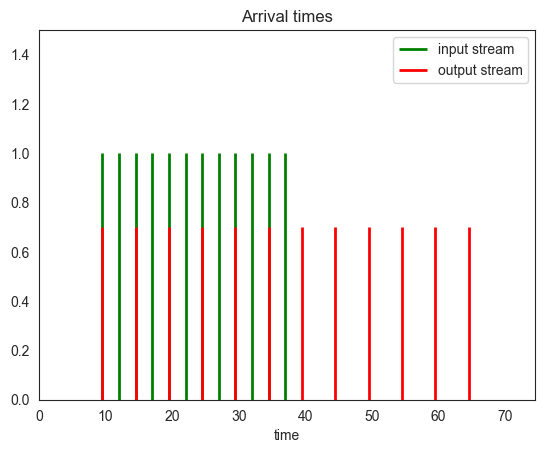

In [16]:
"""
Traffic Shaping
This file shows an example of a traffic shaper whose bucket size is
the same of the packet size and whose bucket rate is one half the input
packet rate.
In addition it shows a method of plotting packet arrival and exit times.
Copyright Dr. Greg M. Bernstein 2014
Released under the MIT license
"""
import simpy
import matplotlib.pyplot as plt

from lib.SimComponents import PacketGenerator, PacketSink, ShaperTokenBucket


if __name__ == '__main__':
    def const_arrival():
        return 2.5

    def const_size():
        return 100.0
    env = simpy.Environment()
    pg = PacketGenerator(env, "SJSU", const_arrival, const_size, initial_delay=7.0, finish=35)
    pg2 = PacketGenerator(env, "SJSU", const_arrival, const_size, initial_delay=7.0, finish=35)
    ps = PacketSink(env,rec_arrivals=True, absolute_arrivals=True)
    ps2 = PacketSink(env,rec_arrivals=True, absolute_arrivals=True)
    source_rate = 8.0*const_size()/const_arrival()  # the average source rate
    bucket_rate = 0.5*source_rate
    bucket_size = 1.0*const_size()
    shaper = ShaperTokenBucket(env, bucket_rate, bucket_size)
    pg.out = ps
    pg2.out = shaper
    shaper.out = ps2
    env.run(until=10000)
    print(ps.arrivals)

    fig, axis = plt.subplots()
    axis.vlines(ps.arrivals, 0.0, 1.0,colors="g", linewidth=2.0, label='input stream')
    axis.vlines(ps2.arrivals, 0.0, 0.7, colors="r", linewidth=2.0, label='output stream')
    axis.set_title("Arrival times")
    axis.set_xlabel("time")
    axis.set_ylim([0, 1.5])
    axis.set_xlim([0, max(ps2.arrivals) + 10])
    axis.legend()
    #axis.set_ylabel("normalized frequency of occurrence")
    #fig.savefig("ArrivalHistogram.png")
    plt.show()

[2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 10.0, 11.25, 12.5, 13.75, 15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 23.75, 26.25, 28.75, 31.25, 33.75, 36.25, 38.75, 41.25, 43.75, 46.25, 48.75, 51.25]


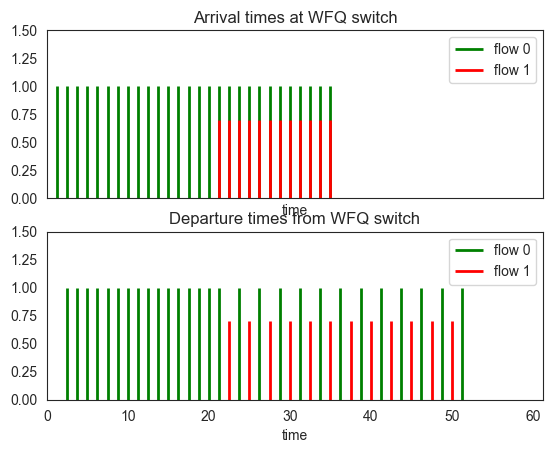

In [17]:
"""
Queueing Disciplines
Explanation to be written... But we have implemented Virtual Clock and Weighted Fair Queueing disciplines in 
the SimComponents.py module and have example code that uses the WFQ component to produce Figure, shown below

    Initial test of the WFQ queueing discipline implementation.
    Copyright 2014 Dr. Greg M. Bernstein

    We base our parameter explorations on the first source. We set the output rate of the
    virtual clock "switch port" at multiple of the first sources rate.
    We also set the "vtick" parameters to the virtual clock switch port relative to this rate.
"""
import simpy
import matplotlib.pyplot as plt

from lib.SimComponents import PacketGenerator, PacketSink, FlowDemux, SnoopSplitter, \
    WFQServer, VirtualClockServer


if __name__ == '__main__':
    def const_arrival():
        return 1.25

    def const_arrival2():
        return 1.25

    def const_size():
        return 100.0
    env = simpy.Environment()
    pg = PacketGenerator(env, "SJSU", const_arrival, const_size, initial_delay=0.0, finish=35, flow_id=0)
    pg2 = PacketGenerator(env, "SJSU", const_arrival2, const_size, initial_delay=20.0, finish=35, flow_id=1)
    ps = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
    ps2 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
    ps_snoop1 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
    ps_snoop2 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True)
    # Set up the virtual clock switch port
    source_rate = 8.0*const_size()/const_arrival()  # the average source rate
    phi_base = source_rate
    switch_port = WFQServer(env, source_rate, [0.5*phi_base, 0.5*phi_base])
    switch_port2 = VirtualClockServer(env, source_rate, [2.0/phi_base, 2.0/phi_base])
    demux = FlowDemux()
    snoop1 = SnoopSplitter()
    snoop2 = SnoopSplitter()
    pg.out = snoop1
    pg2.out = snoop2
    snoop1.out2 = ps_snoop1
    snoop2.out2 = ps_snoop2
    #  Comment out the next 4 lines and uncomment the following 4 lines to compare with virtual clock.
    type = "WFQ"
    snoop1.out1 = switch_port
    snoop2.out1 = switch_port
    switch_port.out = demux
    # snoop1.out1 = switch_port2
    # snoop2.out1 = switch_port2
    # switch_port2.out = demux
    # type = "VC"

    demux.outs = [ps, ps2]
    env.run(until=10000)
    print(ps.arrivals)

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    ax1.vlines(ps_snoop1.arrivals, 0.0, 1.0, colors="g", linewidth=2.0, label='flow 0')
    ax1.vlines(ps_snoop2.arrivals, 0.0, 0.7, colors="r", linewidth=2.0, label='flow 1')
    ax1.set_title("Arrival times at {} switch".format(type))
    ax1.set_xlabel("time")
    ax1.set_ylim([0, 1.5])
    ax1.set_xlim([0, max(ps.arrivals) + 10])
    ax1.legend()
    ax2.vlines(ps.arrivals, 0.0, 1.0, colors="g", linewidth=2.0, label='flow 0')
    ax2.vlines(ps2.arrivals, 0.0, 0.7, colors="r", linewidth=2.0, label='flow 1')
    ax2.set_title("Departure times from {} switch".format(type))
    ax2.set_xlabel("time")
    ax2.set_ylim([0, 1.5])
    ax2.set_xlim([0, max(ps.arrivals) + 10])
    ax2.legend()
    plt.show()
